# Partial Differential Equations

If there's anything that needs serious computing power it's the solution of PDEs. However, you can go a long way to getting intuition on complex problems with simple numerical methods.

Let's take parts of the doped semiconductor model, concentrating on the time-dependent behaviour, simplify the constants, and restrict to one spatial dimension:

\begin{align}
  \frac{\partial p}{\partial t} + \frac{\partial}{\partial x} \left( p \frac{\partial}{\partial x} \left( \frac{1}{p} \right) \right) &= \left( n_i^2 - np \right) + G, \\
  \frac{\partial n}{\partial t} - \frac{\partial}{\partial x} \left( n \frac{\partial}{\partial x} \left( \frac{1}{n} \right) \right) &= \left( n_i^2 - np \right) + G.
\end{align}

This is a pair of coupled PDEs for $n, p$ in terms of physical and material constants, and the quasi-Fermi levels $E_{F_{n,p}}$ depend on $n, p$.

We'll write this in the form

\begin{equation}
  \frac{\partial {\bf y}}{\partial t} + \frac{\partial}{\partial x} \left( {\bf g}({\bf y}) \frac{\partial}{\partial x} {\bf h}({\bf y}) \right) = {\bf f}({\bf y}).
\end{equation}

## Finite differencing

We used finite differencing when looking at IVPs. We introduced a grid of points $x_j$ in space and replace derivatives with finite difference expressions. For example, we saw the forward difference approximation

\begin{equation}
  \left. \frac{\text{d} y}{\text{d} x} \right|_{x = x_j} = \frac{y_{j+1} - y_j}{\Delta x} + {\cal O} \left( \Delta x^2 \right),
\end{equation}

and the central difference approximation

\begin{equation}
  \left. \frac{\text{d} y}{\text{d} x} \right|_{x = x_j} = \frac{y_{j+1} - y_{j-1}}{2 \Delta x} + {\cal O} \left( \Delta x^3 \right).
\end{equation}

This extends to partial derivatives, and to more than one variable. We introduce a grid in time, $t^n$, and denote $y(t^n, x_j) = y^n_j$. Then we can do, say, forward differencing in time and central differencing in space:

\begin{align}
  \left. \frac{\partial y}{\partial t} \right|_{x = x_j, t = t^n} &= \frac{y^{n+1}_{j} - y^{n}_{j}}{\Delta t}, \\
  \left. \frac{\partial y}{\partial x} \right|_{x = x_j, t = t^n} &= \frac{y^{n}_{j+1} - y^{n}_{j-1}}{2 \Delta x}.
\end{align}


Finally, we can evaluate the PDE at a specific point and re-arrange the equation. Assuming we know all the data at $t^n$, the only unknowns will be at $t^{n+1}$, giving the algorithm

\begin{align}
  {\bf y}^{n+1}_{j} &= {\bf y}^{n}_{j} + \Delta t \, {\bf f}^{n}_{j} - \frac{\Delta t}{2 \Delta x} \left( {\bf g}^{n}_{j+1} \frac{1}{2 \Delta x} \left( {\bf h}^{n}_{j+2} - {\bf h}^{n}_{j} \right) - {\bf g}^{n}_{j-1} \frac{1}{2 \Delta x} \left( {\bf h}^{n}_{j} - {\bf h}^{n}_{j-2} \right) \right) \\
  &= {\bf y}^{n}_{j} + \Delta t \, {\bf f}^{n}_{j} - \frac{\Delta t}{4 \left( \Delta x \right)^2} \left( {\bf g}^{n}_{j+1} {\bf h}^{n}_{j+2} - \left( {\bf g}^{n}_{j+1} + {\bf g}^{n}_{j-1} \right) {\bf h}^{n}_{j} + {\bf g}^{n}_{j-1} {\bf h}^{n}_{j-2} \right)
\end{align}

We'll implement that by writing a function that computes the update term (${\bf y}^{n+1}_j - {\bf y}^n_j$), choosing $n_i = 0.1, G = 0.2$:

In [1]:
from __future__ import division
import numpy
from matplotlib import pyplot
%matplotlib notebook

In [11]:
ni = 0.1
G = 0.2

def f(y):
    p = y[0,:]
    n = y[1,:]
    f_vector = numpy.zeros_like(y)
    f_vector[:,:] = ni**2 - n*p + G
    return f_vector

def g(y):
    p = y[0,:]
    n = y[1,:]
    g_vector = numpy.zeros_like(y)
    g_vector[0,:] = p
    g_vector[1,:] = n
    return g_vector

def h(y):
    p = y[0,:]
    n = y[1,:]
    h_vector = numpy.zeros_like(y)
    h_vector[0,:] = 1.0/p
    h_vector[1,:] = 1.0/n
    return h_vector

def update_term(y, dt, dx):
    dydt = numpy.zeros_like(y)
    f_vector = f(y)
    g_vector = g(y)
    h_vector = h(y)
    dydt[:,2:-2] += dt * f_vector[:,2:-2]
    dydt[:,2:-2] -= dt/(4.0*dx**2)*(g_vector[:,3:-1]*h_vector[:,4:] -\
                                  (g_vector[:,3:-1] + g_vector[:,1:-3])*h_vector[:,2:-2] + \
                                  g_vector[:,1:-3]*h_vector[:,:-4])
    return dydt

Now set the initial data to be

\begin{align}
  p &= \sin^2(\pi x) + \frac{1}{2}, \\
  n &= \cos^2(2 \pi x) + \frac{1}{4}.
\end{align}

The spatial domain should be $[0, 1]$. The spatial step size should be $0.01$. The timestep should be $0.0001$. The evolution should be for $100$ steps, to $t=0.01$.

In [19]:
dx = 0.01
dt = 0.00001
Nsteps = 10000
x = numpy.arange(-dx,1+2*dx,dx)
y = numpy.zeros((2,len(x)))
y[0,:] = numpy.sin(numpy.pi*x)**2 + 0.5
y[1,:] = numpy.cos(2.0*numpy.pi*x)**2 + 0.25

In [20]:
for n in range(Nsteps):
    update = update_term(y, dt, dx)
    y += update

<IPython.core.display.Javascript object>


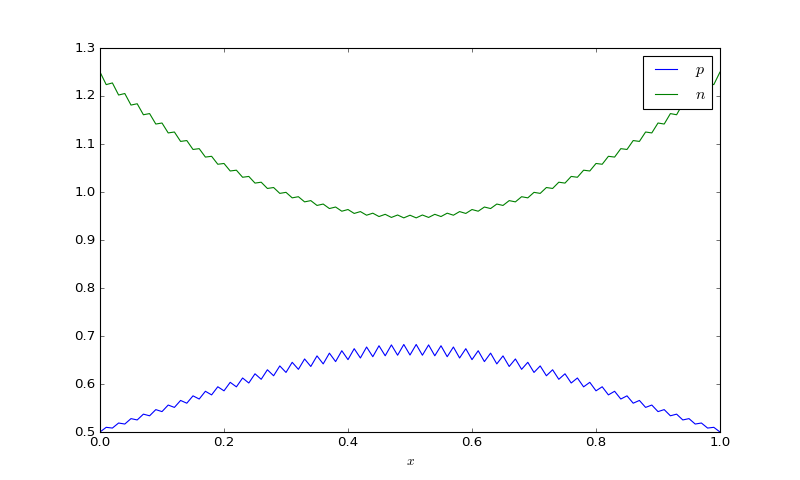

In [21]:
pyplot.figure(figsize=(10,6))
pyplot.plot(x, y[0,:], label=r"$p$")
pyplot.plot(x, y[1,:], label=r"$n$")
pyplot.legend()
pyplot.xlabel(r"$x$")
pyplot.xlim(0, 1)
pyplot.show()

In [15]:
def update_term2(y, dt, dx):
    dydt = numpy.zeros_like(y)
    f_vector = f(y)
    g_vector = g(y)
    h_vector = h(y)
    dydt[:,1:-1] += dt * f_vector[:,1:-1]
    dydt[:,1:-1] -= dt/(4.0*dx**2)*(g_vector[:,2:]*h_vector[:,2:] -\
                                  (g_vector[:,2:] + g_vector[:,:-2])*h_vector[:,1:-1] + \
                                  g_vector[:,:-2]*h_vector[:,:-2])
    return dydt

In [22]:
dx = 0.01
dt = 0.00001
Nsteps = 10000
x = numpy.arange(0,1+dx,dx)
y = numpy.zeros((2,len(x)))
y[0,:] = numpy.sin(numpy.pi*x)**2 + 0.5
y[1,:] = numpy.cos(2.0*numpy.pi*x)**2 + 0.25

for n in range(Nsteps):
    update = update_term2(y, dt, dx)
    y += update

<IPython.core.display.Javascript object>


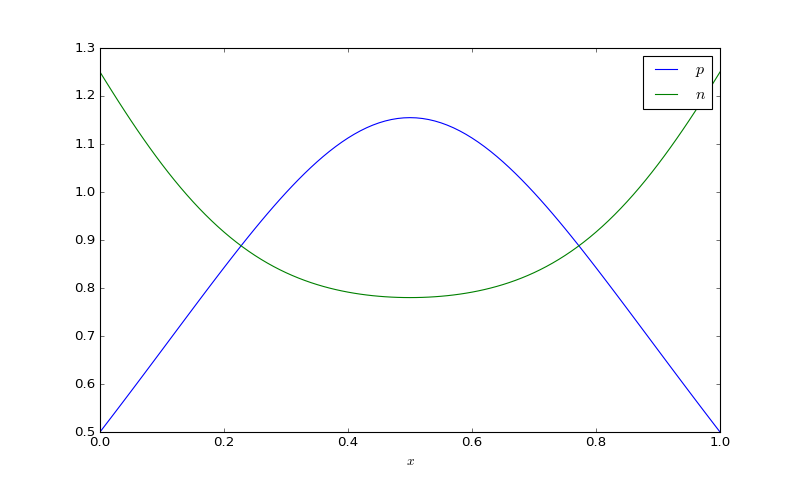

In [23]:
pyplot.figure(figsize=(10,6))
pyplot.plot(x, y[0,:], label=r"$p$")
pyplot.plot(x, y[1,:], label=r"$n$")
pyplot.legend()
pyplot.xlabel(r"$x$")
pyplot.xlim(0, 1)
pyplot.show()

<IPython.core.display.Javascript object>


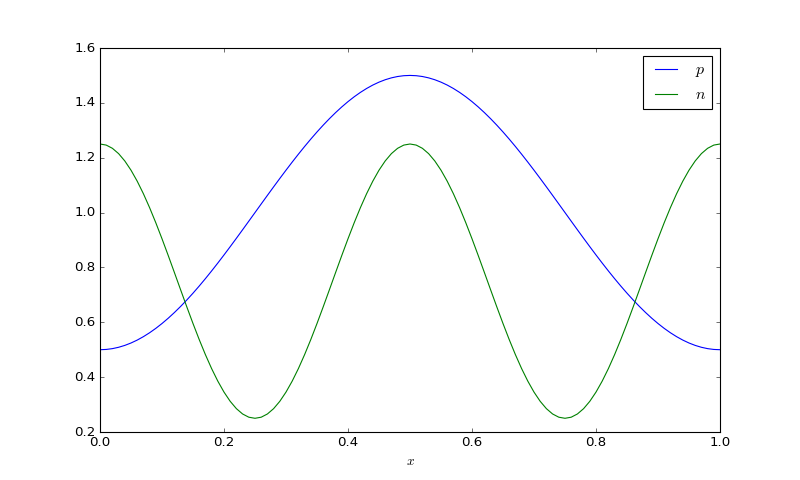

In [18]:
dx = 0.01
dt = 0.0001
Nsteps = 1000
x = numpy.arange(0,1+dx,dx)
y = numpy.zeros((2,len(x)))
y[0,:] = numpy.sin(numpy.pi*x)**2 + 0.5
y[1,:] = numpy.cos(2.0*numpy.pi*x)**2 + 0.25
pyplot.figure(figsize=(10,6))
pyplot.plot(x, y[0,:], label=r"$p$")
pyplot.plot(x, y[1,:], label=r"$n$")
pyplot.legend()
pyplot.xlabel(r"$x$")
pyplot.xlim(0, 1)
pyplot.show()